In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score           

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))
    
## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)
    
def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)


In [2]:
data = pd.read_excel('SMax.xlsx')

data.columns = ['No', 'Month', 'Line', 'Type', 'Owned',
                'BDI','IND-12', 'IND-11', 'IND-10', 'IND-9', 'IND-8', 'IND-7', 'IND-6', 'IND-5', 'IND-4', 'IND-3', 'IND-2', 'IND-1',  
                'M-12', 'M-11', 'M-10', 'M-9', 'M-8', 'M-7', 'M-6', 'M-5', 'M-4', 'M-3', 'M-2', 'M-1', 
                'M-AVG3', 'M-AVG6', 'M-AVG12',
                'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 'TC-3', 'TC-2', 'TC-1', 
                'TC-AVG3','TC-AVG6','TC-AVG12',
                'DAY_CB', 'DAY_HIRE']

data.set_index('Month', inplace=True)

data = data.drop(columns=['No', 'Line', 'Type'], axis=1)

data_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 
                                                       'TC-3', 'TC-2', 'TC-1', 'TC-AVG3','TC-AVG6','TC-AVG12', 'DAY_HIRE'], axis=1)
data_tc    = data[data.Owned == 'TC'].drop(columns=['Owned'], axis=1)


In [3]:
df_owned = data_owned.copy()
df_tc    = data_tc.copy()

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features_own(features, target, n_train, model):
    
    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)
    
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=n_train, shuffle=False)
    
    model.fit(X_train, y_train)
    ##print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    ##print('Test : {:.2f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")
    
    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")
    
    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")
    
    return y_train, y_test, y_pred

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features_tc(features, target, n_train, model):
    
    X = df_tc.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_tc.index.min(), end=df_tc.index.max(), freq='M') 
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False)
    
    #print(n_train, X_train.shape, X_test)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    # Create a consistent range for the x-axis based on the length of y_train
    x_range = range(len(y_train))
    
    plt.plot(x_range, y_train, label="Train")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, '-', label="Test")
    plt.plot(x_range, y_pred_train, '--', label="Train Pred")
    plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, '--', label="Test Pred")
    
    plt.legend(loc='best')
    plt.title(str(model))  # Convert model to string
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")
    
    return y_train, y_test, y_pred

#
# 1. 사선

In [5]:
X_owned = df_owned.drop('DAY_CB', axis=1)
y_owned = df_owned.DAY_CB

n_train = int(len(X_owned)*0.75)

### 사용 모델 :  LinearRegressor, LGBMRegressor, RandomForest, SVM
### 1-1) LinearRegressor
> Max Error:  8868.863 <br>
Mean Absolute Error:  2647.071 <br>
Root Mean Squared Error:  3679.1 <br>
R-Squared:  0.847 <br>
### 1-2) LGBMRegressor
> Max Error:  6739.93 <br>
Mean Absolute Error:  2841.67 <br>
Root Mean Squared Error:  3546.458 <br>
R-Squared:  0.806 <br>
### 1-3) LGBMRegressor
> Max Error:  7870.3 <br>
Mean Absolute Error:  2593.131 <br>
Root Mean Squared Error:  3224.688 <br>
R-Squared:  0.825 <br>
### 1-4) SVM
> Max Error:  10881.112 <br>
Mean Absolute Error:  2470.712 <br>
Root Mean Squared Error:  3535.133 <br>
R-Squared:  0.629 <br>

## * 사선 : LinearRegression 선택

# *******Daily CB 이동 평균 (3/6/12) 적용에도 불구 결측치로 인한 예측 성능 저하 (추측)

Train Score :  0.9334441779157896 ,  Test Score :  0.847321488137142


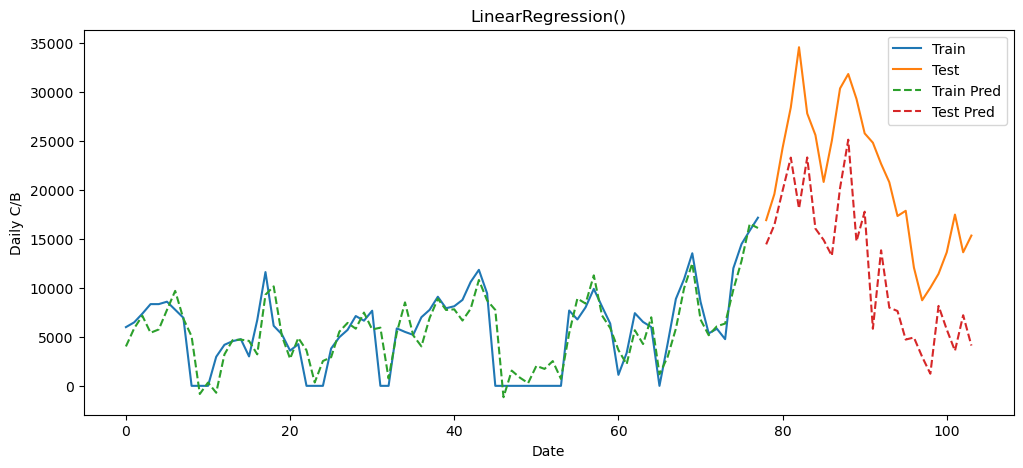

In [6]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features_own(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('Train Score : ', lr.score(X_train, y_train),', ','Test Score : ', lr.score(X_test, y_test))

In [7]:
show_reg_result(y_test,y_pred)

Max Error:  8868.863
Mean Absolute Error:  2647.071
Root Mean Squared Error:  3679.1
R-Squared:  0.847


# 2. 용선 

### 사용 모델 :  LinearRegressor,  RandomForest, SVM
### 1-1) LinearRegressor
> Max Error:  4924.522 <br>
Mean Absolute Error:  1457.838 <br>
Root Mean Squared Error:  1767.093 <br>
R-Squared:  0.967 <br>
### 2-2) LGBMRegressor
> Max Error:  6569.363 <br>
Mean Absolute Error:  1844.526 <br>
Root Mean Squared Error:  2450.705 <br>
R-Squared:  0.919 <br>
### 2-3) RandomForest
> Max Error:  5104.2 <br>
Mean Absolute Error:  1328.423 <br>
Root Mean Squared Error:  1825.579 <br>
R-Squared:  0.954 <br>
### 2-4) SVM
>Max Error:  2769.11 <br>
Mean Absolute Error:  1050.514 <br>
Root Mean Squared Error:  1287.874 <br>
R-Squared:  0.936

## * 용선 : LinearRegression 선택

In [13]:
df_tc = data_tc.copy()
X_tc   = df_tc.drop('DAY_CB', axis=1)
y_hire = df_tc.DAY_HIRE
y_tc   = df_tc.DAY_CB

(0.9926182203830761, 0.9671266388364236)

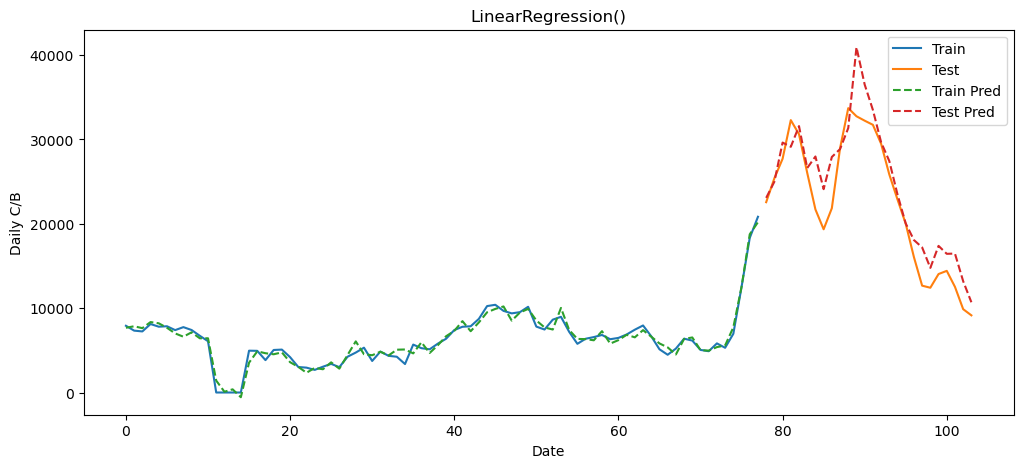

In [14]:
from sklearn.linear_model import LinearRegression

y_train, y_test, y_pred = eval_on_features_tc(X_tc, y_tc, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)